In [841]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

In [784]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load SXR phantoms

In [3]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples_fine_discretization/psis.npy')
sxr_samples = np.load('../dataset_generation/sxr_samples_fine_discretization/sxr_samples.npy')
alphas = np.load('../dataset_generation/sxr_samples_fine_discretization/alpha_random_values.npy')
trim_val = np.load('../dataset_generation/sxr_samples_fine_discretization/trimming_values.npy')

In [4]:
psis.shape

(2000, 240, 80)

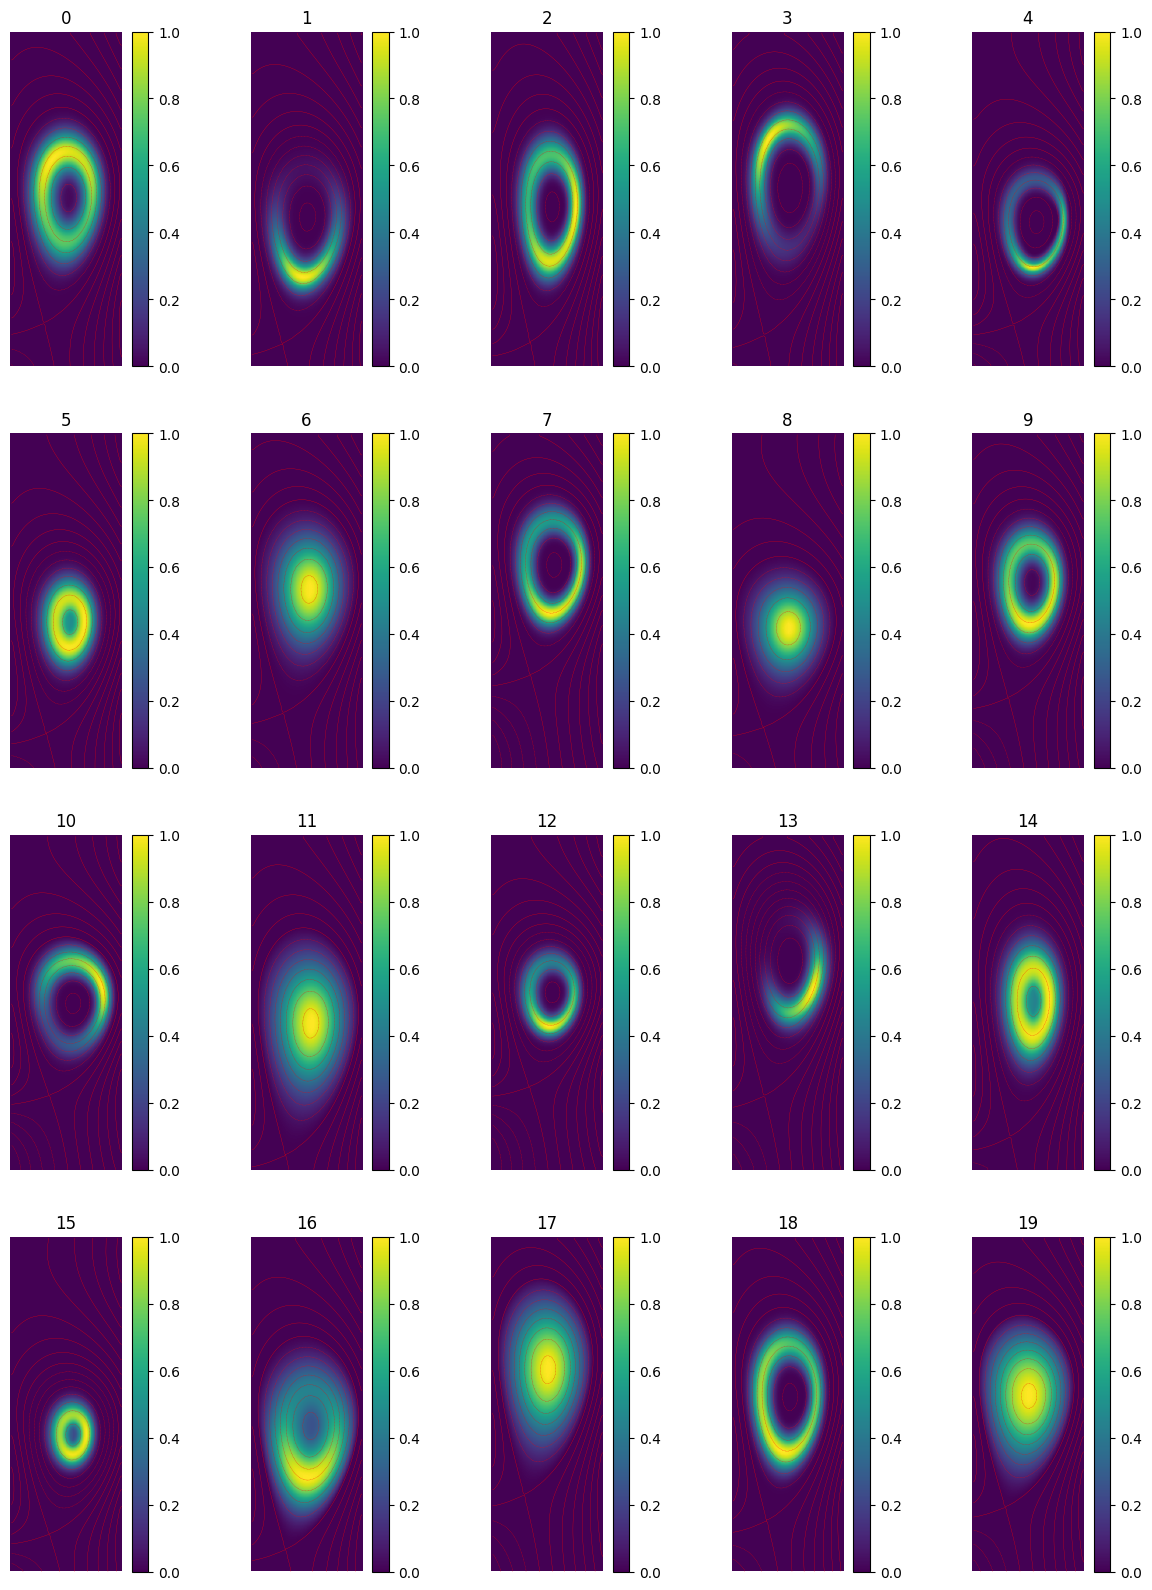

In [106]:
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        im=ax[i,j].imshow(sxr_samples[i*5+j, 0, :, :].squeeze())
        ax[i, j].contour(psis[i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(i*5+j))
plt.show()

# Hyperparameter tuning

We run hyperparameter tuning techniques on 100 SXR phantoms.

In [824]:
idx = 0
ground_truth=sxr_samples[idx,0,:,:].squeeze()
psi=psis[idx,:,:]
alpha=alphas[idx]
trim_val_=trim_val[idx,:]

In [825]:
fwd_fine=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr_fine_grid.npz')
fwd_coarse=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz')
tomo_data = fwd_fine.dot(ground_truth.flatten())
# plt.plot(tomo_data)
# plt.plot(np.ones(tomo_data.size)*np.mean(tomo_data))
sigma_err = 0.05 * np.mean(tomo_data)
print("sigma_err = {:.2e}".format(sigma_err))

sigma_err = 7.79e-03


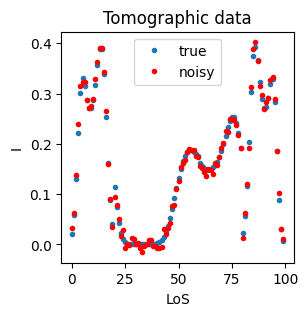

In [826]:
reg_fct_type = "anisotropic"
# Define functionals
f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi, sigma_err=sigma_err, reg_fct_type=reg_fct_type, alpha=alpha, plot=True)
mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=f.dim_shape[1:], trim_values_x=trim_val_)

## Hyperparameter tuning

**Regularization parameter**

In [ ]:
# Tune regularization parameter
#reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["SAPG"],
#                                                    sapg_max_iter=int(1e4), reg_params=np.logspace(-6,0,7), plot=True)
reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["CV_full"], ground_truth=ground_truth,
                                                    with_pos_constraint=True, clipping_mask=mask_core,
                                                    cv_strategy="random",
                                                    reg_params=np.logspace(-4,0,9), plot=True)

**Anisotropic Parameter**

In [799]:
g.diffusion_coefficient.alpha

np.float64(0.02105268352105909)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



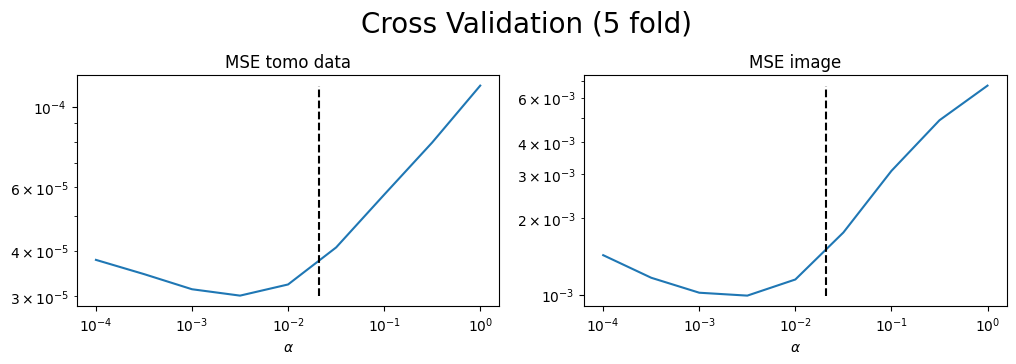

In [798]:
anis_param_tuning_data = hyper_tune.anis_param_tuning(f, g, reg_param=0.03,
                                                        tuning_techniques=["CV_full"], ground_truth=ground_truth,
                                                        with_pos_constraint=True, clipping_mask=mask_core,
                                                        cv_strategy="random",
                                                        anis_params=np.logspace(-4,0,9), plot=True)

In [11]:
# N=int(5e3+1)
# import time
# st=time.time()
# x0=f.forward_model_linop.T(f.noisy_tomo_data.reshape(-1))
# reg_param=0.05
# obj=f+reg_param*g
# st=time.time()
# st0=st
# for n in range(N):
#     x0-= (1/obj.diff_lipschitz)*obj.grad(x0)
#     x0=np.clip(x0,0,None)
#     x0*=mask_core
#     if (n+1) % 1000 == 0:
#         print(time.time()-st)
#         st=time.time()
# print(time.time()-st0)


In [ ]:
# plt.imshow(x0)
#plt.colorbar()

In [810]:
g = hyper_tune._redefine_anis_param_logprior(g, anis_param_tuning_data["CV_full"][0, np.argmin(anis_param_tuning_data["CV_full"][1,:])])

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


In [818]:
tt=time.time()
im_MAP = bcomp.compute_MAP(f, g, 0.03, with_pos_constraint=True, clipping_mask=mask_core)
print(time.time()-tt)

INFO -- [2024-12-07 19:20:51.350739] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-07 19:20:51.591464] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-07 19:20:51.811984] Iteration 1_977
	iteration: 1977
	N_iter: 1978
	RelError[x]: 0
INFO -- [2024-12-07 19:20:51.812447] Stopping Criterion satisfied -> END
0.46764659881591797


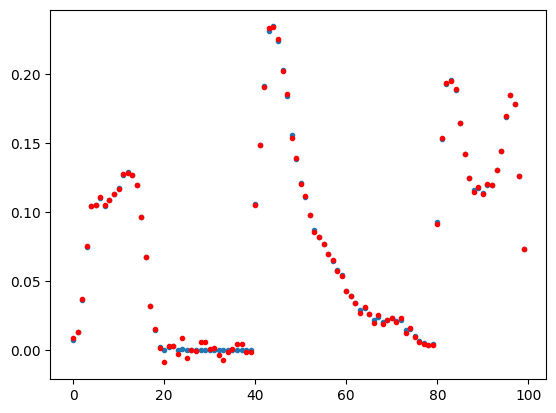

In [814]:
plt.plot(fwd_coarse.dot(im_MAP.flatten()), '.')
plt.plot(f.noisy_tomo_data, '.r')

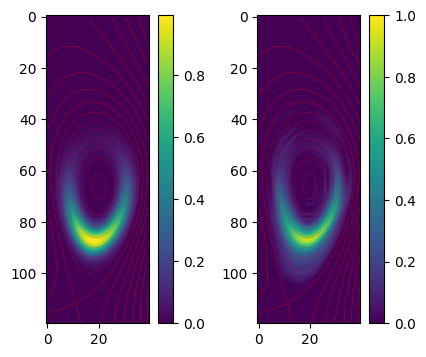

In [815]:
fig,ax=plt.subplots(1,2,figsize=(5,4))
# im=ax[0].imshow(ground_truth.squeeze())
# plt.colorbar(im, ax=ax[0])
# ax[0].contour(psi, origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[0].imshow(skimt.resize(ground_truth.squeeze(), f.dim_shape[1:], anti_aliasing=False, mode='edge'))
plt.colorbar(im, ax=ax[0])
ax[0].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[1].imshow((im_MAP).squeeze(), vmax=1)
plt.colorbar(im, ax=ax[1])
ax[1].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
plt.show()

In [816]:
# fig,ax=plt.subplots(1,2,figsize=(5,4))
# im=ax[0].imshow(ground_truth.squeeze())
# plt.colorbar(im, ax=ax[0])
# ax[0].contour(psi, origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
# im=ax[1].imshow((im_MAP).squeeze(), vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[1])
# ax[1].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
# plt.show()

In [817]:
np.max(im_MAP)

np.float64(0.9304605674539433)

# Uncertainty Quantification

In [845]:
uq_data = bcomp.run_ula(f, g, 0.03, psi, trim_val_,
            with_pos_constraint=True,
            clip_iterations="core",
            compute_stats_wrt_MAP=True,
            estimate_quantiles=True)

INFO -- [2024-12-07 19:47:51.398614] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-07 19:47:51.694507] Iteration 955
	iteration: 955
	N_iter: 956
	RelError[x]: 0
INFO -- [2024-12-07 19:47:51.695123] Stopping Criterion satisfied -> END
Running 100000 ULA iterations
iteration  10000
iteration  20000
iteration  30000
iteration  40000
iteration  50000
iteration  60000
iteration  70000
iteration  80000
iteration  90000
iteration  100000


In [844]:
len(uq_data)

9

In [843]:
uq_data["empirical_quantiles"].shape

(3, 120, 40)